In [17]:
import pandas as pd
import os
import numpy as np
import librosa.display
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_io as tfio
from scipy.io import wavfile

In [18]:
data_folder = "/home/lrbutler/Desktop/ELP_CNN_Spectrogram/data/"
meta_file = "nn_ele_hb_00-24hr_TrainingSet.txt"

In [19]:
data = pd.read_csv(os.path.join(data_folder, meta_file), delimiter='\t')
len(data)

3240

# Distribution of the Length of the Labeled Signals

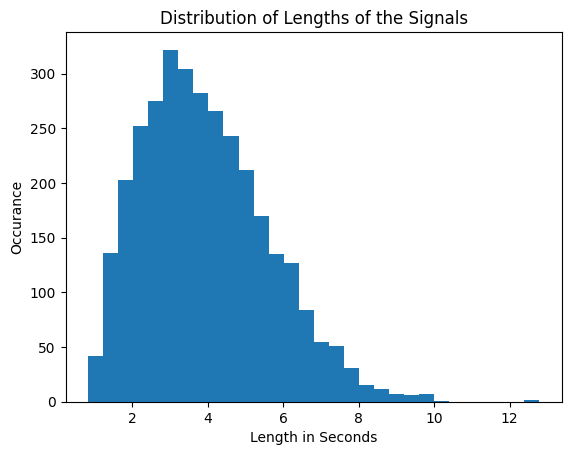

In [20]:
lengths = data['End Time (s)'] - data['Begin Time (s)']
plt.hist(lengths, bins=30)
plt.xlabel("Length in Seconds")
plt.ylabel("Occurance")
plt.title("Distribution of Lengths of the Signals")
plt.show()

5 second window
0 - 512 hz

less than 3 seconds might be an issue
low power signals

Use select windows for positive examples
exclue selection windows then capture clear examples.

tune spectrogram

# Distribution of Low and High Frequency Ranges

Text(0, 0.5, 'Occurance')

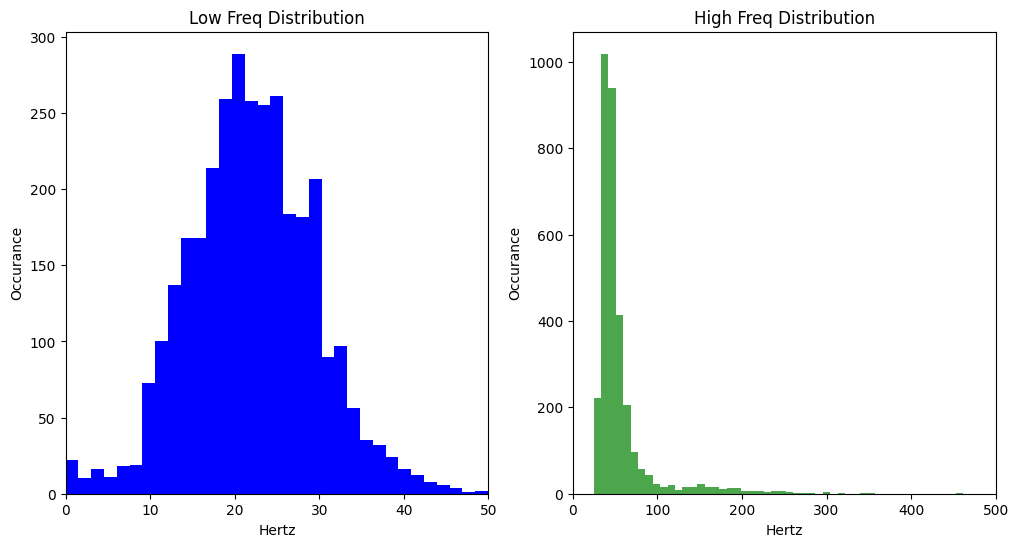

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot histograms
ax1.hist(data['Low Freq (Hz)'], bins=50, color='blue')
ax1.set_title('Low Freq Distribution')
ax1.set_xlim([0, 50])
ax1.set_xlabel('Hertz')
ax1.set_ylabel('Occurance')

ax2.hist(data['High Freq (Hz)'], bins=50, alpha=0.7, color='green')
ax2.set_title('High Freq Distribution')
ax2.set_xlim([0, 500])
ax2.set_xlabel('Hertz')
ax2.set_ylabel('Occurance')

In [22]:
from scipy.signal import butter, lfilter

def down_sample(audio, input_sr, output_sr):
    """
    input:
        audio: 1D vector
        input_sr: sampling rate (hz)
        output_sr: target sampling rate (hz)

    output:
        1D vector of down sampled audio    
    """
    hop = float(input_sr) / float(output_sr)
    if hop < 1:
        print("Target hop less than one. Down sampling cannot occure.")
        return audio
    
    hop = tf.cast(tf.math.round(hop), tf.int32)
    down_sample = audio[::hop]

    return down_sample

def normalize_audio(audio):
    audio = tf.cast(audio, tf.float32)
    mean = tf.reduce_mean(audio)
    stddev = tf.math.reduce_std(audio)
    normalized_audio = (audio - mean) / stddev
    return normalized_audio

def butter_lowpass(cutoff, fs, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

def stft_hann_window(audio):
    stft = tf.signal.stft(
        audio,
        frame_length=1024,
        frame_step=200,
        window_fn=tf.signal.hann_window
    )

    return tf.math.log(tf.abs(stft) + 1e-10).numpy().T



In [23]:
window_length = 5 # seconds
low_freq = 0 # hz
high_freq = 512 # hz
target_sr = 2000 # hz

Opening file: /home/lrbutler/Desktop/ELP_CNN_Spectrogram/data/nn01a_20180126_000000.wav
9


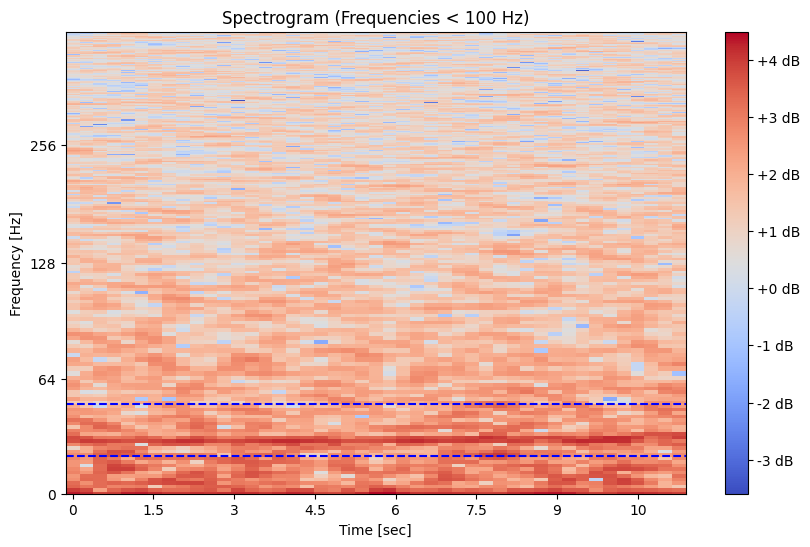

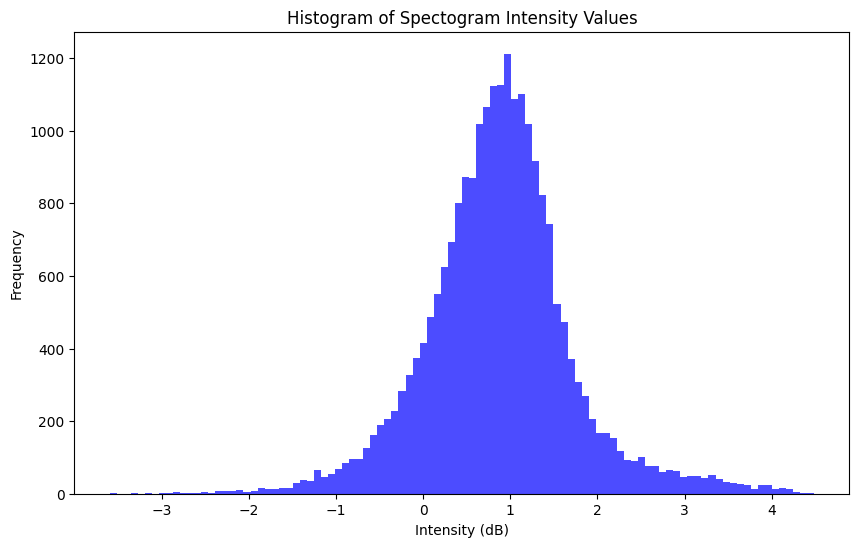

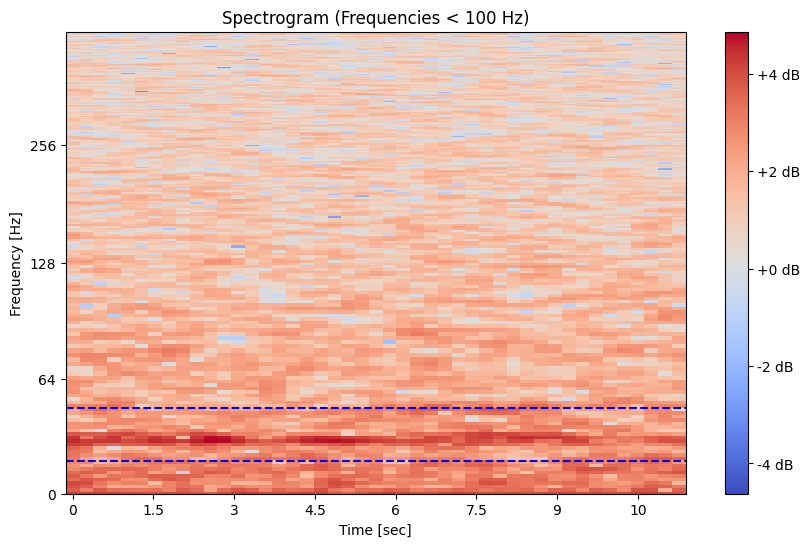

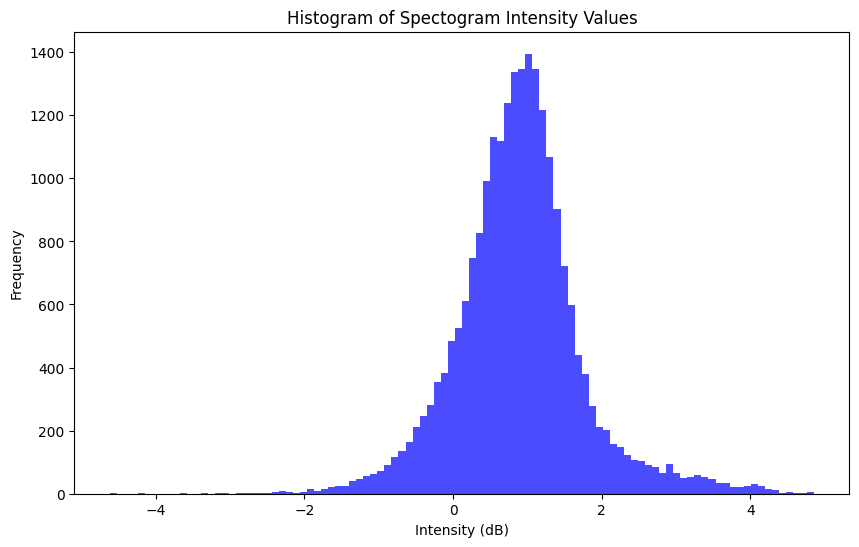

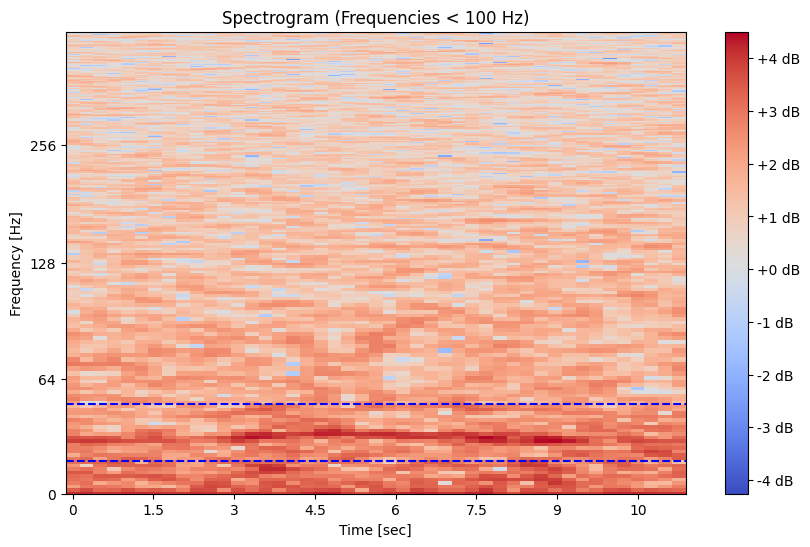

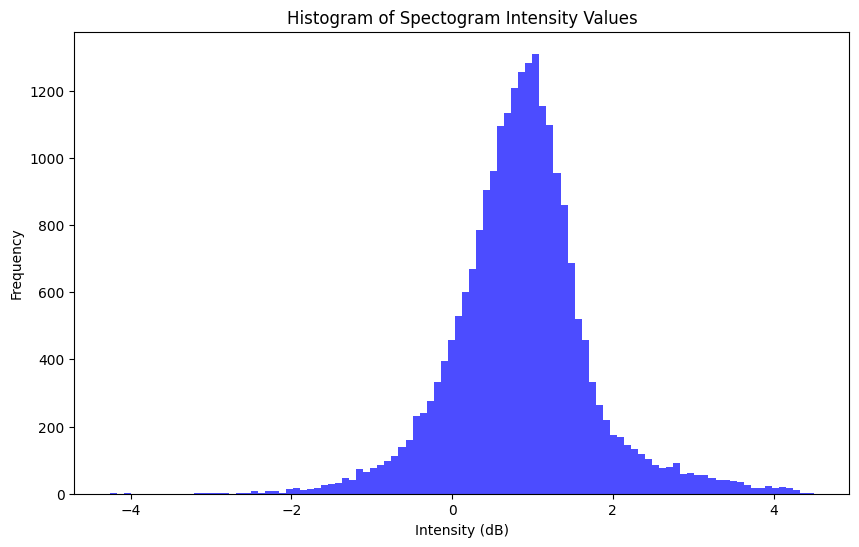

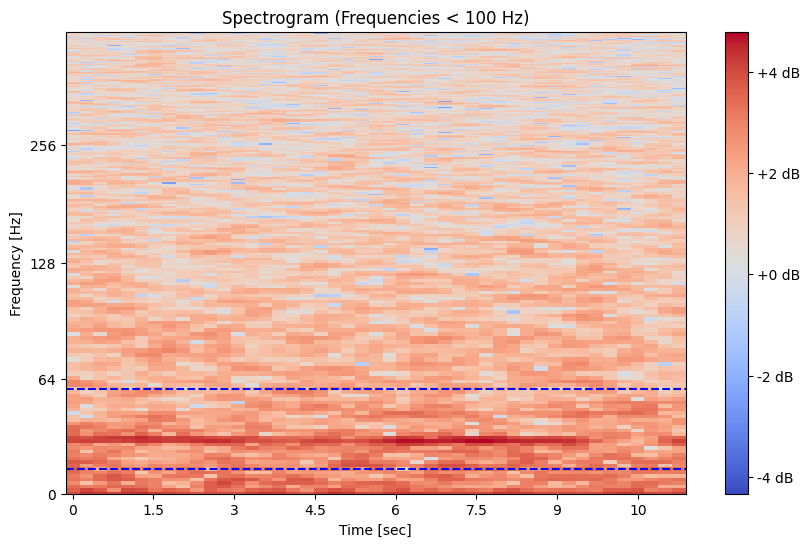

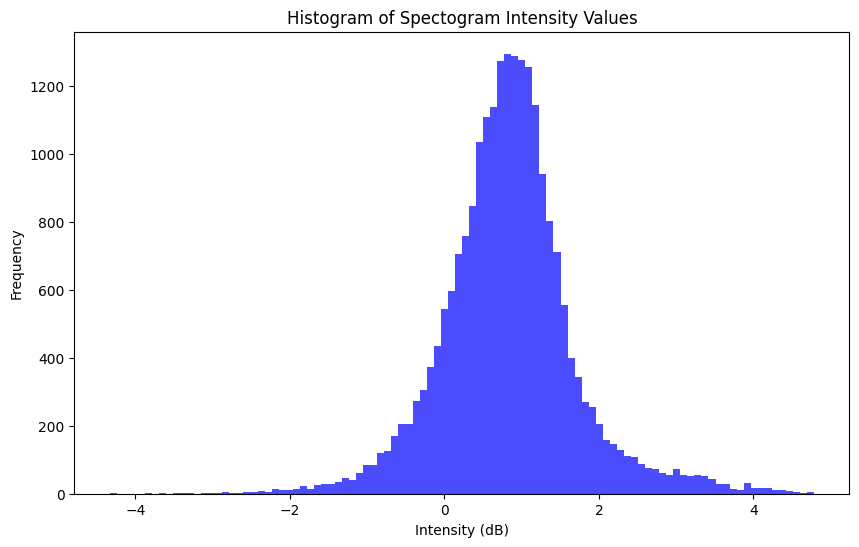

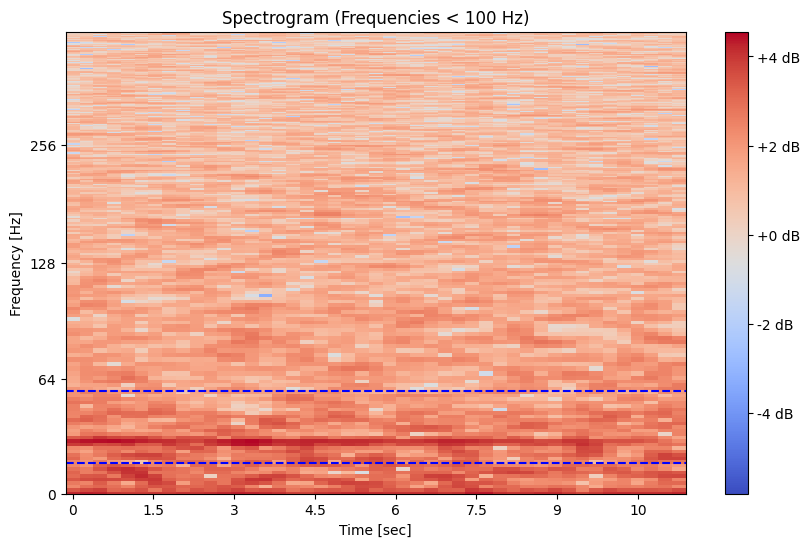

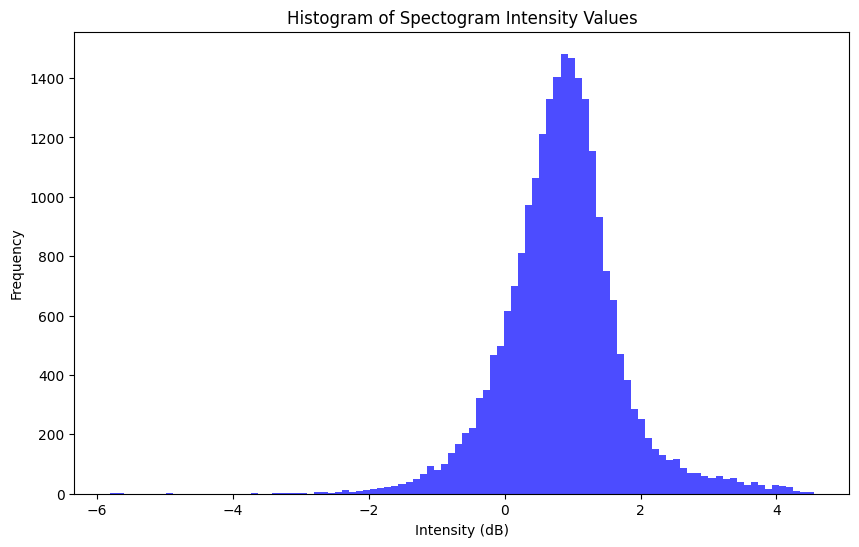

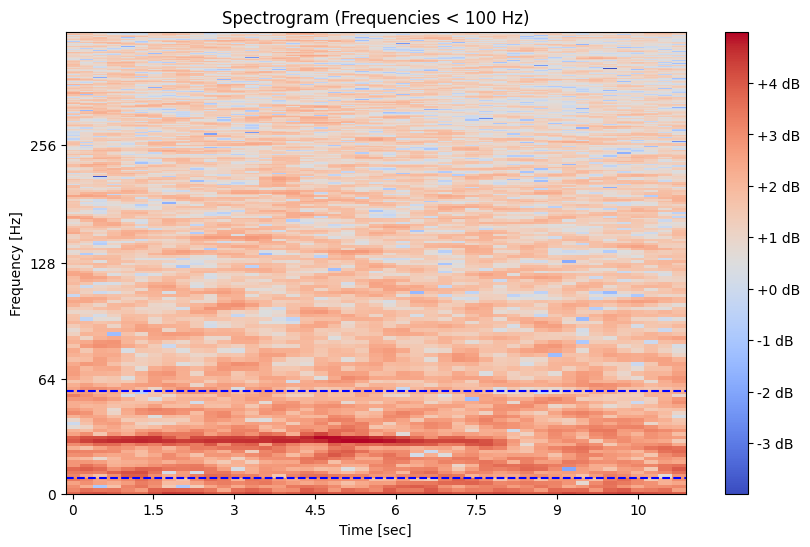

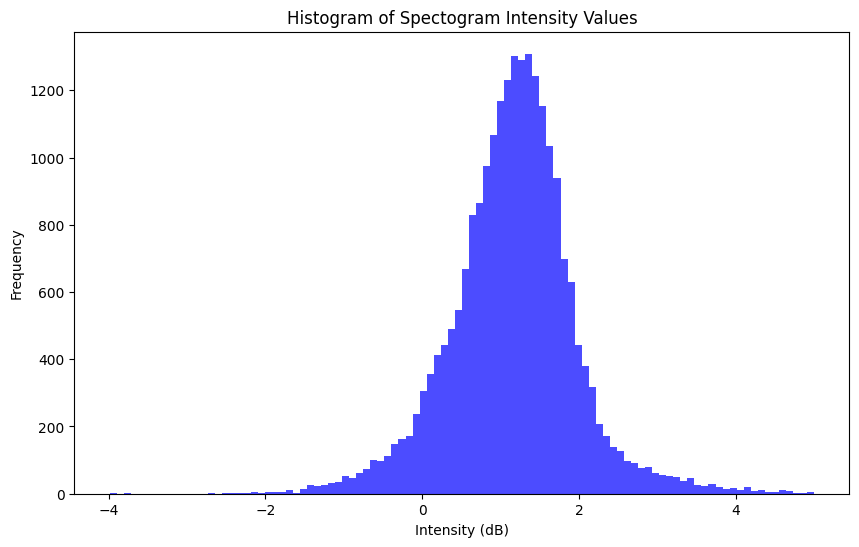

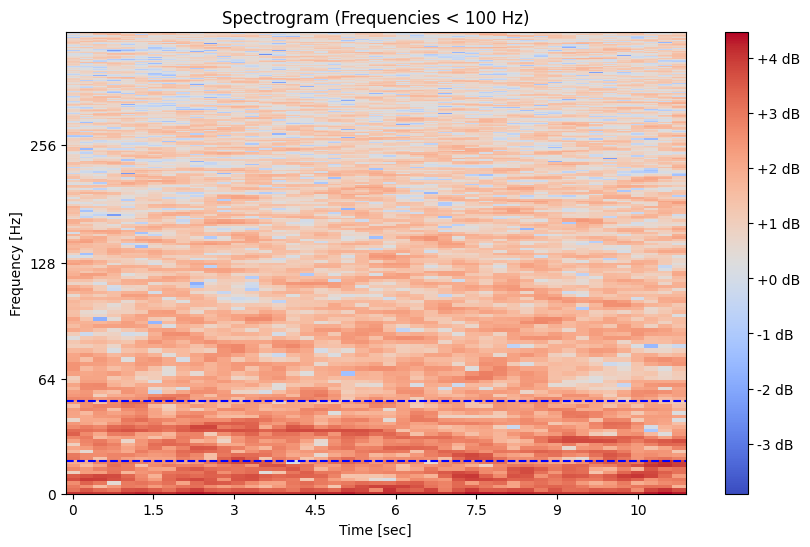

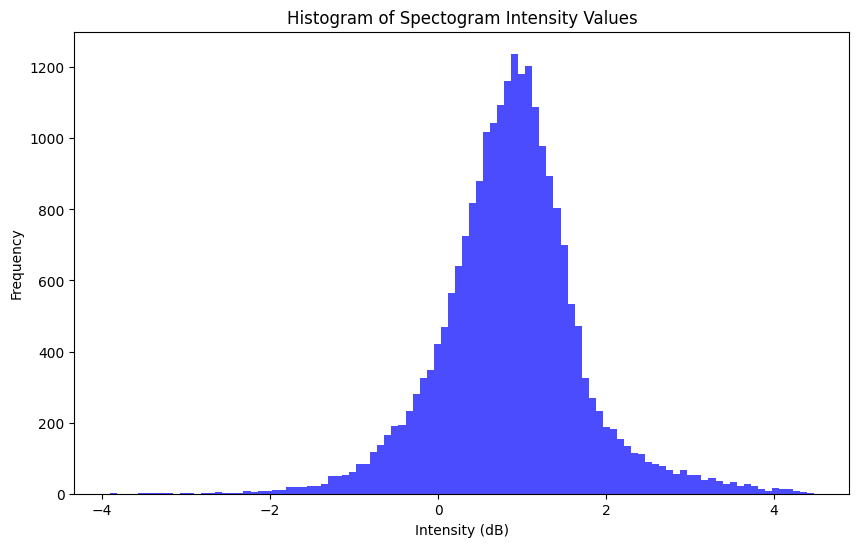

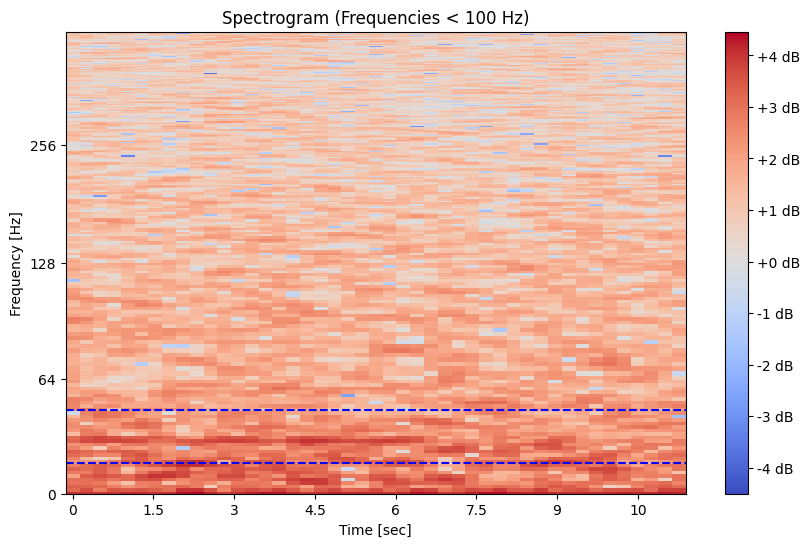

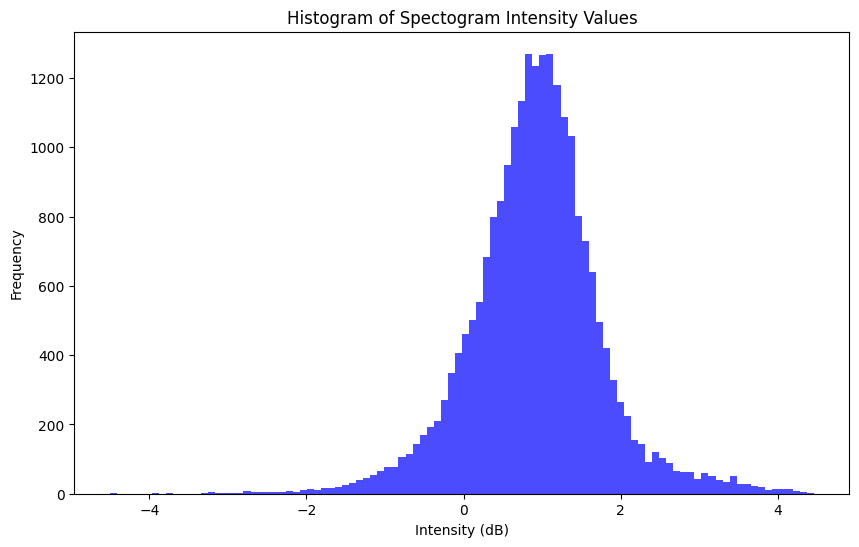

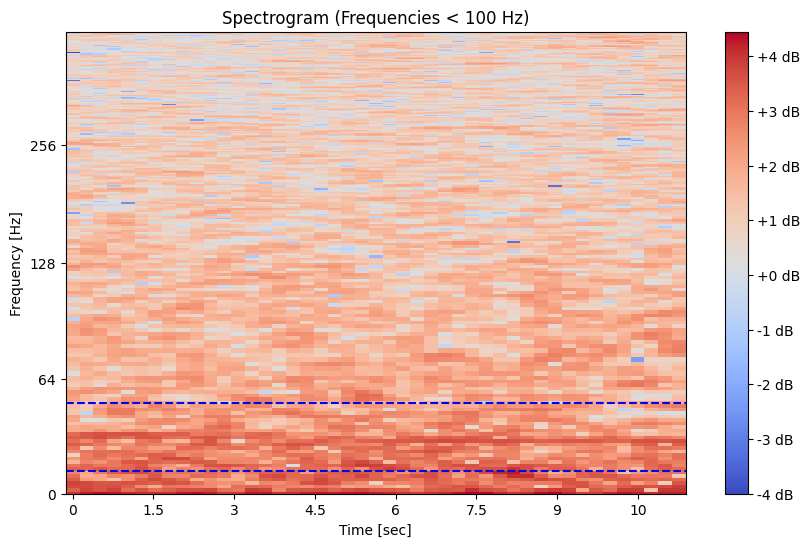

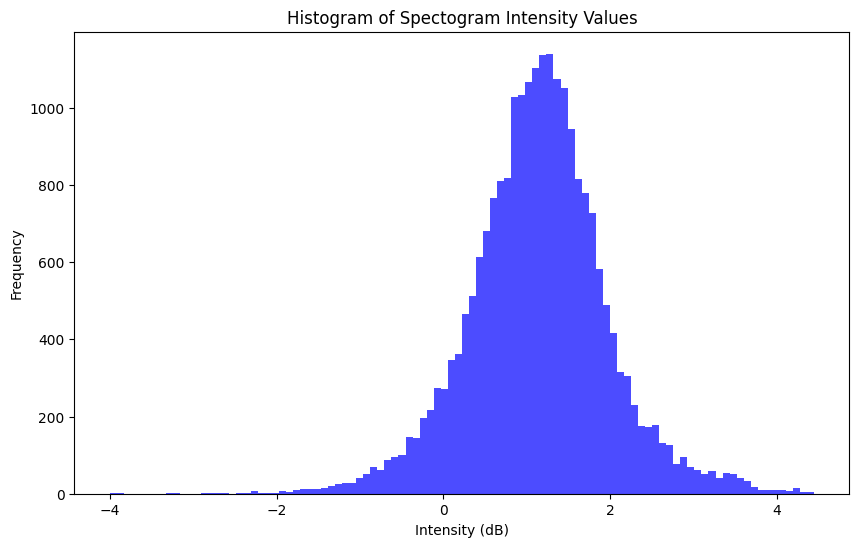

In [27]:

for file in set(data['Begin File']):
    target_file = os.path.join(data_folder, file)

    if os.path.exists(target_file):
        print(f"Opening file: {target_file}")

        sampling_rate, audio = wavfile.read(target_file)

        audio = normalize_audio(audio)

        clips = data[data['Begin File'] == file]

        print(len(clips))
        for offset, start, stop, low, high in zip(clips['File Offset (s)'], clips['Begin Time (s)'], clips['End Time (s)'], clips['Low Freq (Hz)'], clips['High Freq (Hz)']):
            
            # Clip the audio
            starting_pos = offset
            stopping_pos = offset + window_length
            selection_start, selection_end = int(2 * sampling_rate), int((2 + (stop - start)) * sampling_rate)
            begin_index, end_index = int(starting_pos * sampling_rate), int(stopping_pos * sampling_rate)
            audio_clip = audio[begin_index: end_index]

            # Process
            audio_clip = down_sample(audio_clip, sampling_rate, target_sr)
            #audio_clip = lowpass_filter(audio_clip, high_freq, target_sr)
            stft = stft_hann_window(audio_clip)

            # Display the spectrogram with upper and low bounds as specified in the selection table.
            plt.figure(figsize=(10, 6))
            librosa.display.specshow(stft, sr=target_sr, x_axis="time", y_axis='log')
            plt.colorbar(format='%+2.0f dB')
            plt.title('Spectrogram')
            plt.xlabel('Time [sec]')
            plt.ylabel('Frequency [Hz]')
            plt.ylim(0, 500)  # Set the y-axis limit to show frequencies under 100 Hz
            plt.axhline(y=low, color='blue', linestyle='--', label=f'Low Freq: {low} Hz')
            plt.axhline(y=high, color='blue', linestyle='--', label=f'High Freq: {high} Hz')
            plt.show()

            # Display a histogram of instensity values
            plt.figure(figsize=(10, 6))
            plt.hist(stft.flatten(), bins=100, color='blue', alpha=0.7)
            plt.title('Histogram of Spectogram Intensity Values')
            plt.xlabel('Intensity (dB)')
            plt.ylabel('Frequency')
            plt.show()
            